In [1]:
import numpy as np
import pandas as pd
from keras.layers import Flatten,Dropout,Conv2D, MaxPooling2D,Dense
from keras import Sequential
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import pickle
import cv2

In [2]:
with open('german-traffic-signs\\train.p','rb') as f:
    training_data = pickle.load(f)
with open('german-traffic-signs\\test.p','rb') as f:
    testing_data = pickle.load(f)
with open('german-traffic-signs\\valid.p','rb') as f:
    validation_data = pickle.load(f)

In [3]:
X_train,y_train = training_data.get('features'),training_data.get('labels')
X_valid,y_valid = validation_data.get('features'),validation_data.get('labels')
X_test,y_test = testing_data.get('features'),testing_data.get('labels')

In [4]:
X_train.shape,X_test.shape,X_valid.shape

((34799, 32, 32, 3), (12630, 32, 32, 3), (4410, 32, 32, 3))

In [5]:
y_train_cat = to_categorical(y_train)
y_valid_cat = to_categorical(y_valid)
y_test_cat = to_categorical(y_test)

In [6]:
def convert_to_gray(img):
    return cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
def equalize_image(img):
    return cv2.equalizeHist(img)
def preprocess_image(img):
    return (equalize_image(convert_to_gray(img)))/255

In [7]:
X_train_preprocess = np.array(list(map(preprocess_image,X_train)))
X_valid_preprocess = np.array(list(map(preprocess_image,X_valid)))
X_test_preprocess = np.array(list(map(preprocess_image,X_test)))

Text(0.5,1,'Preprocessed Image')

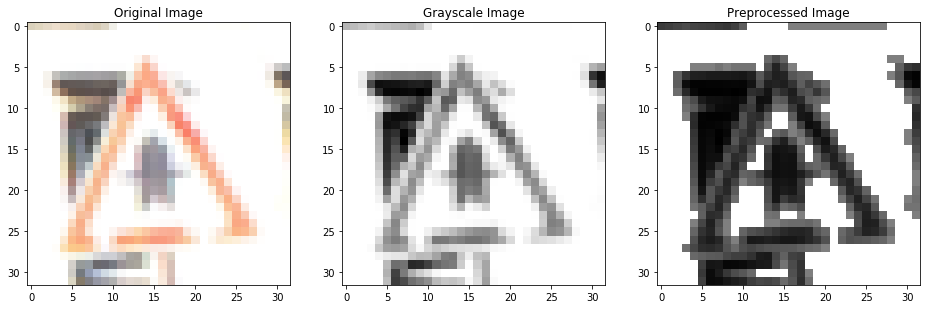

In [8]:
_, ax = plt.subplots(1,3,figsize=(16,5))
r = np.random.randint(0,len(X_train_preprocess)-1)
ax[0].imshow(X_train[r],cmap='gray')
ax[0].set_title("Original Image")
ax[1].imshow(convert_to_gray(X_train[r]),cmap='gray')
ax[1].set_title("Grayscale Image")
ax[2].imshow(X_train_preprocess[r],cmap='gray')
ax[2].set_title("Preprocessed Image")

In [33]:
def base_model():
    model = Sequential()
    model.add(Conv2D(64,(5,5),input_shape=(32,32,1),activation='relu'))
    model.add(Conv2D(64,(5,5),activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(32,(3,3),activation='relu'))
    model.add(Conv2D(32,(3,3),activation='relu'))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(43,activation='softmax'))
    model.compile(loss=categorical_crossentropy,optimizer=Adam(lr=0.003),metrics=['acc'])
    return model

In [28]:
model = base_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 64)        1664      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 64)        102464    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 10, 10, 32)        18464     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 32)          9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)              

In [9]:
X_train_vol = X_train_preprocess.reshape(-1,32,32,1)
X_valid_vol = X_valid_preprocess.reshape(-1,32,32,1)
X_test_vol = X_test_preprocess.reshape(-1,32,32,1)

In [69]:
log = model.fit(X_train_vol,y_train_cat,batch_size=512,epochs=10,validation_data=(X_valid_vol,y_valid_cat),shuffle=True)

Train on 34799 samples, validate on 4410 samples
Epoch 1/10
34799/34799 [==============================] - 13s 367us/step - loss: 2.3175 - acc: 0.3760 - val_loss: 0.6984 - val_acc: 0.7932
Epoch 2/10
34799/34799 [==============================] - 12s 341us/step - loss: 0.6097 - acc: 0.8096 - val_loss: 0.3340 - val_acc: 0.8916
Epoch 3/10
34799/34799 [==============================] - 12s 353us/step - loss: 0.3172 - acc: 0.8986 - val_loss: 0.2407 - val_acc: 0.9297
Epoch 4/10
34799/34799 [==============================] - 12s 352us/step - loss: 0.2273 - acc: 0.9286 - val_loss: 0.2062 - val_acc: 0.9417
Epoch 5/10
34799/34799 [==============================] - 12s 353us/step - loss: 0.1791 - acc: 0.9439 - val_loss: 0.1567 - val_acc: 0.9535
Epoch 6/10
34799/34799 [==============================] - 12s 352us/step - loss: 0.1441 - acc: 0.9544 - val_loss: 0.1542 - val_acc: 0.9562
Epoch 7/10
34799/34799 [==============================] - 12s 353us/step - loss: 0.1193 - acc: 0.9632 - val_loss: 0.1

Text(0,0.5,'Loss')

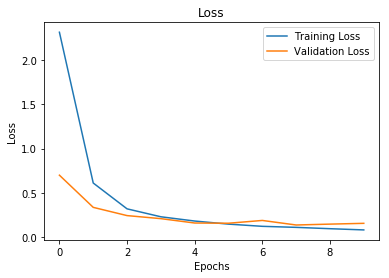

In [70]:
plt.plot(log.history['loss'],label='Training Loss')
plt.plot(log.history['val_loss'],label='Validation Loss')
plt.legend()
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")

Text(0,0.5,'Accuracy')

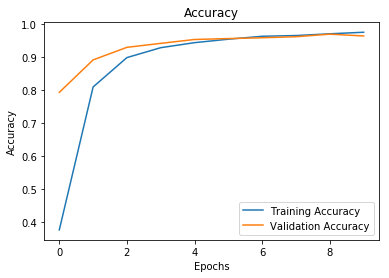

In [71]:
plt.plot(log.history['acc'],label='Training Accuracy')
plt.plot(log.history['val_acc'],label='Validation Accuracy')
plt.legend()
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

In [72]:
model.evaluate(X_test_vol,y_test_cat)

12630/12630 [==============================] - 4s 284us/step


[0.23222371981474066, 0.9433095803830893]

In [10]:
from keras.preprocessing.image import ImageDataGenerator

In [13]:
datagen = ImageDataGenerator(width_shift_range=0.15,height_shift_range=0.15,zoom_range=0.25,shear_range=0.2,rotation_range=25)
datagen.fit(X_train_vol)

In [17]:
batches = datagen.flow(X_train_vol,y_train_cat,batch_size=15)
X_batch,y_batch = next(batches)

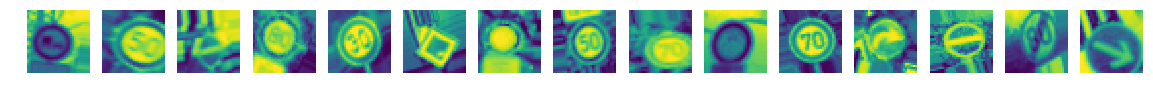

In [22]:
_,ax = plt.subplots(1,15,figsize=(20,4))
for i,img in enumerate(X_batch):
    ax[i].imshow(img.reshape(32,32))
    ax[i].axis('off')

In [29]:
model = base_model()
log = model.fit_generator(datagen.flow(X_train_vol,y_train_cat,batch_size=128),steps_per_epoch=200,epochs=30,validation_data=(X_valid_vol,y_valid_cat),shuffle=True)

Epoch 1/30
200/200 [==============================] - 14s 68ms/step - loss: 3.3537 - acc: 0.0924 - val_loss: 2.4241 - val_acc: 0.3501
Epoch 2/30
200/200 [==============================] - 12s 62ms/step - loss: 2.2200 - acc: 0.3418 - val_loss: 1.2771 - val_acc: 0.5816
Epoch 3/30
200/200 [==============================] - 12s 62ms/step - loss: 1.5809 - acc: 0.5063 - val_loss: 0.7500 - val_acc: 0.7417
Epoch 4/30
200/200 [==============================] - 13s 66ms/step - loss: 1.2216 - acc: 0.6147 - val_loss: 0.4752 - val_acc: 0.8293
Epoch 5/30
200/200 [==============================] - 13s 66ms/step - loss: 0.9850 - acc: 0.6917 - val_loss: 0.3201 - val_acc: 0.8989
Epoch 6/30
200/200 [==============================] - 12s 61ms/step - loss: 0.8454 - acc: 0.7313 - val_loss: 0.2550 - val_acc: 0.9224 - ET - ETA: 2s - loss:  - ETA: 1s - los
Epoch 7/30
200/200 [==============================] - 12s 62ms/step - loss: 0.7156 - acc: 0.7767 - val_loss: 0.1931 - val_acc: 0.9315
Epoch 8/30
200/200 [==

Text(0,0.5,'Loss')

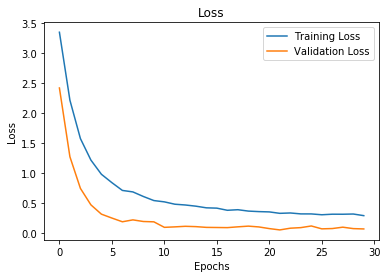

In [30]:
plt.plot(log.history['loss'],label='Training Loss')
plt.plot(log.history['val_loss'],label='Validation Loss')
plt.legend()
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")

Text(0,0.5,'Accuracy')

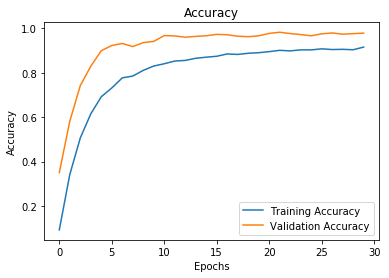

In [31]:
plt.plot(log.history['acc'],label='Training Accuracy')
plt.plot(log.history['val_acc'],label='Validation Accuracy')
plt.legend()
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

In [32]:
model.evaluate(X_test_vol,y_test_cat)

12630/12630 [==============================] - 4s 283us/step


[0.2502025202588825, 0.9428345209723508]